Data sourcing:


*   https://www.scitepress.org/Link.aspx?doi=10.5220/0012176800003595
*   https://www.kaggle.com/datasets/sgluege/noisy-drone-rf-signal-classification?resource=download




In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls ./drive/MyDrive/NatSecHackathon/

class_stats.csv  dataset.pt  feature_data.csv  SNR_stats.csv


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

dataset_folder = './drive/MyDrive/NatSecHackathon/'

# load data
dataset_dict = torch.load(dataset_folder + 'dataset.pt')
dataset_dict.keys()

x_iq = dataset_dict['x_iq']
x_spec = dataset_dict['x_spec']
y = dataset_dict['y']
snrs = dataset_dict['snr']
duty_cycle = dataset_dict['duty_cycle']

In [4]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft

# Function to extract features from spectrograms
def extract_spectrogram_features(spectrogram):
    mean_val = np.mean(spectrogram)
    median_val = np.median(spectrogram)
    std_val = np.std(spectrogram)
    skewness = skew(spectrogram.flatten())
    kurt = kurtosis(spectrogram.flatten())
    return [mean_val, median_val, std_val, skewness, kurt]

def extract_iq_features(iq_data):
    # Assuming iq_data is a 2D array with shape (2, N)
    iq_features = []

    for channel in iq_data:
        mean_val = np.mean(channel)
        median_val = np.median(channel)
        std_val = np.std(channel)
        skewness = skew(channel)
        kurt = kurtosis(channel)

        # Frequency domain features
        freq_domain = fft(channel)
        dominant_freq = np.argmax(np.abs(freq_domain))
        freq_variance = np.var(np.abs(freq_domain))

        iq_features.extend([mean_val, median_val, std_val, skewness, kurt, dominant_freq, freq_variance])

    return iq_features

# Function to create a DataFrame with extracted features
def create_feature_dataframe(x_iq, x_spec, y, snrs, duty_cycle):
    features = []
    for iq, spec, label, snr, duty in zip(x_iq, x_spec, y, snrs, duty_cycle):
        iq = iq.numpy()
        spec = spec.numpy()
        spectrogram_features = extract_spectrogram_features(spec)
        iq_features = extract_iq_features(iq)
        features.append(spectrogram_features + iq_features + [snr.item(), duty.item(), label.item()])

    columns = ['spec_mean', 'spec_median', 'spec_std', 'spec_skew', 'spec_kurt',
               'iq_mean_ch1', 'iq_median_ch1', 'iq_std_ch1', 'iq_skew_ch1', 'iq_kurt_ch1', 'iq_dom_freq_ch1', 'iq_freq_var_ch1',
               'iq_mean_ch2', 'iq_median_ch2', 'iq_std_ch2', 'iq_skew_ch2', 'iq_kurt_ch2', 'iq_dom_freq_ch2', 'iq_freq_var_ch2',
               'snr', 'duty_cycle', 'label']
    df = pd.DataFrame(features, columns=columns)
    return df

# Extracting features and creating DataFrame
feature_df = create_feature_dataframe(x_iq, x_spec, y, snrs, duty_cycle)

# Save to CSV
feature_df.to_csv('./drive/MyDrive/NatSecHackathon/feature_data.csv', index=False)

KeyboardInterrupt: 

In [5]:
feature_df = pd.read_csv('./drive/MyDrive/NatSecHackathon/feature_data.csv')
feature_df.head()

,spec_mean,spec_median,spec_std,spec_skew,spec_kurt,iq_mean_ch1,iq_median_ch1,iq_std_ch1,iq_skew_ch1,iq_kurt_ch1,...,iq_mean_ch2,iq_median_ch2,iq_std_ch2,iq_skew_ch2,iq_kurt_ch2,iq_dom_freq_ch2,iq_freq_var_ch2,snr,duty_cycle,label
0,-3.637979e-12,-0.000012,0.062586,0.169530,16.255502,0.003213,0.001475,0.676350,-0.010893,0.374092,...,0.011833,0.003971,0.684076,0.028673,0.412927,4303,4073.8910,4,0.894043,0
1,-9.094947e-13,-0.000005,0.064442,0.085722,23.583504,-0.000413,0.000093,0.692559,-0.008682,0.421718,...,-0.000032,-0.000040,0.704355,0.008453,0.489249,4026,5251.3066,8,0.960754,0
2,1.455191e-11,-0.000040,0.064087,-0.006238,-0.001093,-0.000763,-0.004860,0.689954,0.008326,0.028002,...,0.013592,0.013559,0.697350,0.005973,0.024975,5267,1713.5328,-14,0.011841,0
3,-1.409717e-11,0.000016,0.065625,0.202271,27.154668,-0.000957,0.000897,0.706944,0.000939,-0.039948,...,-0.000356,0.001565,0.710269,0.006335,-0.042513,1328,6895.0117,26,1.000000,0
4,-1.164153e-10,-0.000019,0.061619,0.106800,20.097824,-0.006655,-0.005142,0.654963,-0.002497,0.575189,...,0.004486,0.000000,0.673030,0.020369,0.599841,907,4295.3460,6,0.851562,0


In [ ]:
!pip install cvnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 4.2 MB/s eta 0:00:00
  Created wheel for cvnn: filename=cvnn-2.0-py2.py3-none-any.whl size=47610 sha256=a12436fd061279061e2056a9f648615e2d3387713141b442f2eae47c1acaac5c
  Stored in directory: /root/.cache/pip/wheels/91/7c/d5/a4816f12ef5f955ed83cd22822d376f57aa0bc00b7ea2c4486
Successfully built cvnn


In [ ]:
x_iq.size()

torch.Size([98705, 2, 16384])

In [ ]:
y.size()

torch.Size([98705])

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
real_part = x_iq[:, 0, :]  # Select the first channel (real part)
imaginary_part = x_iq[:, 1, :]  # Select the second channel (imaginary part)
x_iq.shape

torch.Size([98705, 2, 16384])

In [ ]:
print("Shape of training data:", train_data.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing data:", test_data.shape)
print("Shape of testing labels:", test_labels.shape)

Shape of training data: (78964, 16384)
Shape of training labels: (78964,)
Shape of testing data: (19741, 16384)
Shape of testing labels: (19741,)


In [54]:
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras import regularizers

# Define the model architecture
model = Sequential()
model.add(InputLayer(input_shape=(2, 256, 1)))

# First Convolutional Layer (Conv1)
model.add(Conv2D(32, kernel_size=(1, 16), strides=1, padding='valid', activation='relu'))

# Second Convolutional Layer (Conv2)
model.add(Conv2D(32, kernel_size=(2, 16), strides=1, padding='valid', activation='relu'))

# Dropout Layer to prevent overfitting
model.add(Dropout(0.5))

# Flatten layer to prepare for the fully connected layers
model.add(Flatten())

# First Fully Connected Layer with 256 nodes
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4)))

# Final Fully Connected Layer with softmax activation for classification
model.add(Dense(7, activation='softmax', kernel_regularizer=regularizers.L1L2(l1=0.2, l2=0.4),
    bias_regularizer=regularizers.L2(0.2), activity_regularizer=regularizers.L2(1e-5) ))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 2, 241, 32)        544       
                                                                 
 conv2d_18 (Conv2D)          (None, 1, 226, 32)        32800     
                                                                 
 dropout_19 (Dropout)        (None, 1, 226, 32)        0         
                                                                 
 flatten_19 (Flatten)        (None, 7232)              0         
                                                                 
 dense_36 (Dense)            (None, 1024)              7406592   
                                                                 
 dense_37 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 7447111 (28.41 MB)
Trainable params: 74

<ipython-input-56-c3839554c1f5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_iq_tensor = torch.tensor(x_iq).numpy()
<ipython-input-56-c3839554c1f5>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).numpy()
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(98705, 7)
(98705, 2, 256, 1)
(98705, 7)
(78964, 2, 256, 1)
(19741, 2, 256, 1)
(78964, 7)
(19741, 7)
Epoch 1/10
3949/3949 [==============================] - 124s 31ms/step - loss: 1.6617 - accuracy: 0.5326 - val_loss: 1.6013 - val_accuracy: 0.5368
Epoch 2/10
3949/3949 [==============================] - 122s 31ms/step - loss: 1.5438 - accuracy: 0.5329 - val_loss: 1.5440 - val_accuracy: 0.5368
Epoch 3/10
3949/3949 [==============================] - 122s 31ms/step - loss: 1.5371 - accuracy: 0.5336 - val_loss: 1.5413 - val_accuracy: 0.5368
Epoch 4/10
3949/3949 [==============================] - 120s 30ms/step - loss: 1.5415 - accuracy: 0.5347 - val_loss: 1.5435 - val_accuracy: 0.5371
Epoch 5/10
3949/3949 [==============================] - 121s 31ms/step - loss: 1.5425 - accuracy: 0.5357 - val_loss: 1.5283 - val_accuracy: 0.5379
Epoch 6/10
3949/3949 [==============================] - 119s 30ms/step - loss: 1.5427 - accuracy: 0.5359 - val_loss: 1.5753 - val_accuracy: 0.5369
Epoch 7/10
3949/3

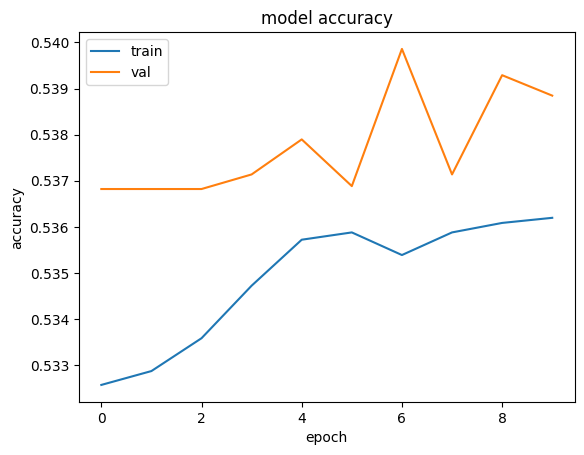

In [56]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


x_iq_tensor = torch.tensor(x_iq).numpy()
y_tensor = torch.tensor(y).numpy()

y_tensor_2d = y_tensor.reshape(-1, 1)  # Shape: (10, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(categories='auto', sparse=False)

# Fit and transform the array to one-hot encoding
one_hot_encoded = encoder.fit_transform(y_tensor_2d)

print(one_hot_encoded.shape)

keep_size = int(1 * 98705)

# Randomly choose indices to keep from the first dimension
keep_indices = np.random.choice(98705, size=keep_size, replace=False)

# Select the subset of the array with the chosen indices in the first dimension
reshaped_data = x_iq_tensor[:, :, ::64]
arr_subset = reshaped_data[keep_indices, :, :]
one_hot_encoded_subset = one_hot_encoded[keep_indices, :]
arr_subset = np.expand_dims(arr_subset, axis=-1)

print(arr_subset.shape)
print(one_hot_encoded_subset.shape)
X_train, X_val, y_train, y_val = train_test_split(arr_subset, one_hot_encoded_subset, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy}")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

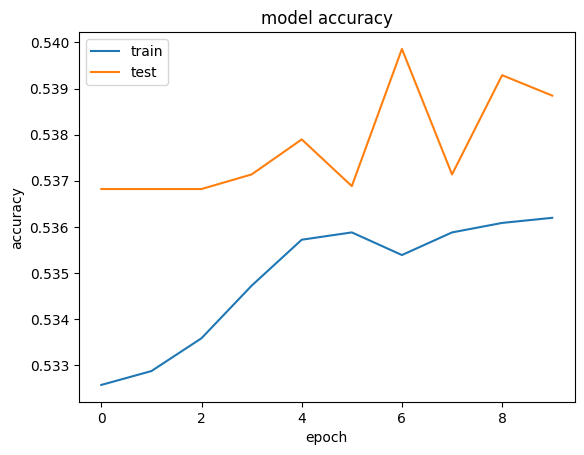

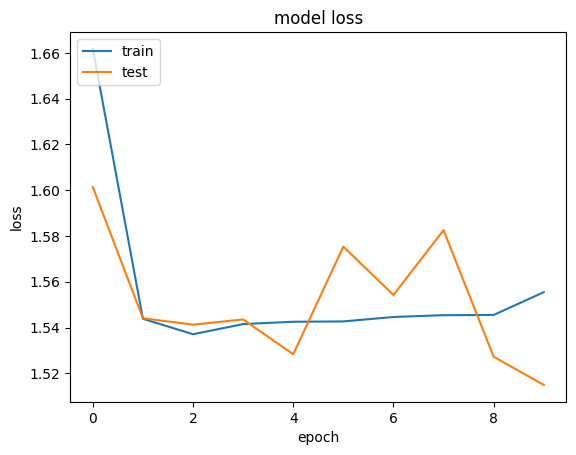

In [57]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
y_predict = model.predict(X_val)
print(np.round(y_predict))

617/617 [==============================] - 3s 4ms/step
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [81]:
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras import regularizers

# Define the model architecture
model2 = Sequential()
model2.add(InputLayer(input_shape=(2, 256, 1)))

# First Convolutional Layer (Conv1)
model2.add(Conv2D(32, kernel_size=(1, 16), strides=1, padding='valid', activation='relu'))

# Second Convolutional Layer (Conv2)
model2.add(Conv2D(32, kernel_size=(2, 16), strides=1, padding='valid', activation='relu'))

# Dropout Layer to prevent overfitting
model2.add(Dropout(0.5))

# Flatten layer to prepare for the fully connected layers
model2.add(Flatten())

# First Fully Connected Layer with 256 nodes
model2.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4)))

# Final Fully Connected Layer with softmax activation for classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 2, 241, 32)        544       
                                                                 
 conv2d_22 (Conv2D)          (None, 1, 226, 32)        32800     
                                                                 
 dropout_21 (Dropout)        (None, 1, 226, 32)        0         
                                                                 
 flatten_21 (Flatten)        (None, 7232)              0         
                                                                 
 dense_40 (Dense)            (None, 1024)              7406592   
                                                                 
 dense_41 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 7440961 (28.39 MB)
Trainable params: 74

In [89]:
y

tensor([0, 0, 0,  ..., 4, 4, 4])

In [91]:
import keras
x_iq_tensor = torch.tensor(x_iq).numpy()
y_tensor = torch.tensor(y).numpy()
y_tensor_bin = np.where((y == 0) | (y == 1) | (y == 2), 1, 0)

y_tensor_2d = y_tensor_bin.reshape(-1, 1)

# Select the subset of the array with the chosen indices in the first dimension
reshaped_data = x_iq_tensor[:, :, ::64]
arr_subset = reshaped_data[keep_indices, :, :]
y_tensor_2d = y_tensor_2d[keep_indices, :]
arr_subset = np.expand_dims(arr_subset, axis=-1)

print(arr_subset.shape)
print(y_tensor_2d.shape)
X_train, X_val, y_train, y_val = train_test_split(arr_subset, y_tensor_2d, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)
# Train the model
history2 = model2.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2)



<ipython-input-91-8ad212cf6b5d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_iq_tensor = torch.tensor(x_iq).numpy()
<ipython-input-91-8ad212cf6b5d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y).numpy()


(98705, 2, 256, 1)
(98705, 1)
(78964, 2, 256, 1)
(19741, 2, 256, 1)
(78964, 1)
(19741, 1)
Epoch 1/5
3949/3949 [==============================] - 114s 29ms/step - loss: 298974.8750 - accuracy: 0.8716 - val_loss: 344959.2188 - val_accuracy: 0.8720
Epoch 2/5
3949/3949 [==============================] - 115s 29ms/step - loss: 395612.4375 - accuracy: 0.8716 - val_loss: 448255.9375 - val_accuracy: 0.8720
Epoch 3/5
3949/3949 [==============================] - 114s 29ms/step - loss: 505827.0312 - accuracy: 0.8716 - val_loss: 565342.2500 - val_accuracy: 0.8720
Epoch 4/5
3949/3949 [==============================] - 116s 29ms/step - loss: 630148.2500 - accuracy: 0.8716 - val_loss: 696936.5625 - val_accuracy: 0.8720
Epoch 5/5
617/617 [==============================] - 3s 6ms/step - loss: 844967.7500 - accuracy: 0.8654
Test Accuracy: 0.5300136804580688
